In [7]:
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [8]:
def diff(a, b):
    return np.mean(np.abs(a.astype(np.float64) - b.astype(np.float64)))

In [9]:
# TODO add sigma-kernel dependency -> kernel = 4*sigma + 1 
def set_noise(img, sigma=2) :
    noise = np.random.normal(0, sigma, size=img.shape)
    return np.clip(img + noise, 0, 255).astype(np.uint8)

In [10]:
def Gaussian_filter(sigma):
    n = 4*sigma + 1
    gaus_filter = np.array([range(-n//2+1, n//2+1, 1) for _ in range(n)])
    gaus_filter = np.square(gaus_filter) + np.square(gaus_filter.T)
    gaus_filter = (1/(2*np.pi*np.square(sigma)))*np.exp(-gaus_filter/(2*np.square(sigma)))
    return gaus_filter

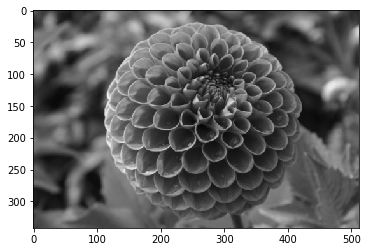

In [11]:
image = cv2.imread("flw.jpg")
plt.imshow(image, 'gray')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

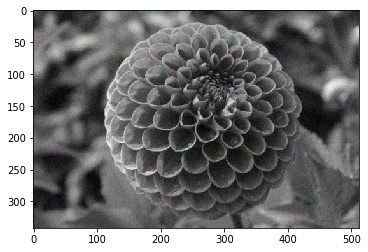

In [12]:
noisy_image = set_noise(image, 8)
plt.imshow(noisy_image, 'gray')
plt.savefig("noisy.jpg")
plt.show

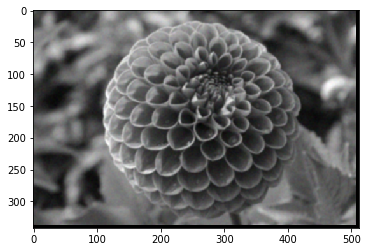

14.106204784934906

In [13]:
smooth_image = np.zeros(noisy_image.shape)
n = 5
gaus_filter = Gaussian_filter(1)
for i in range(noisy_image.shape[0] - n):
    for j in range(noisy_image.shape[1] - n):
        smooth_image[i, j, 0] = (noisy_image[i:i+n, j:j+n, 0]*gaus_filter).sum()
        smooth_image[i, j, 1] = (noisy_image[i:i+n, j:j+n, 1]*gaus_filter).sum()
        smooth_image[i, j, 2] = (noisy_image[i:i+n, j:j+n, 2]*gaus_filter).sum()

plt.imshow(smooth_image/np.max(smooth_image), 'gray')
plt.savefig("result.png")
plt.show()

diff(image, smooth_image)

# Bilateral

In [14]:
def phi(alpha,C,h,sig):
    a = np.maximum(alpha-2*h*(sig**2),0)
    b = 2*np.sqrt(2)*h*(sig**2)/np.sqrt(C)
    inner = -a/b
    return np.exp(inner)

In [15]:
def bilateral(y, sig, h=1):
    s1 = s2 = 4*sig + 1
    n1, n2 = y.shape[:2]
    c = y.shape[2] if y.ndim == 3 else 1
    x = np.zeros(y.shape)
    Z = np.zeros((n1, n2, *[1] * (y.ndim - 2)))
    for i in range(s1, n1-s1):
        for j in range(s2, n2-s2):
            tmp1 = 0
            tmp2 = 0
            for k in range(-s1, s1 + 1):
                for l in range(-s2, s2 + 1):
                    dist2 = ((y[i + k, j + l] - y[i, j])**2).mean()
                    tmp1 += phi(dist2,c,h,sig) * y[i + k][j + l]   
                    tmp2 += phi(dist2,c,h,sig)
            x[i][j] = tmp1
            Z[i][j] = tmp2 
    Z[Z == 0] = 1
    x = x / Z
    return x

In [16]:
start_time =time.time()
bil_image = bilateral(noisy_image,8,1)
elapse_time_bil = time.time() -start_time

In [17]:
elapse_time_bil

109.04758191108704

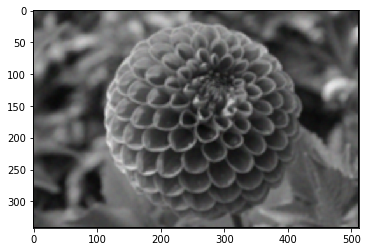

In [18]:
bil_image = np.clip(bil_image,0,255).astype(np.uint8)
plt.imshow(bil_image, 'gray')
plt.show()

In [19]:
diff(image, bil_image)

6.269422743055555

# NLM

In [20]:
def phi_nl(alpha,C,h,sig,P):
    a = np.maximum(alpha-2*h*(sig**2),0)
    b = 2*np.sqrt(2)*h*(sig**2)/np.sqrt(C*P)
    inner = -a/b
    return np.exp(inner)

In [21]:
def nlm(y, sig, p1=1, p2=1, h=1):
    s1 = s2 = 4*sig + 1
    n1, n2 = y.shape[:2]
    c = y.shape[2] if y.ndim == 3 else 1
    
    x = np.zeros(y.shape)
    Z = np.zeros((n1, n2, *[1] * (y.ndim-2)))
    
    P = (2*p1+1)*(2*p2+1)
    for i in range(s1, n1-s1-p1):
        for j in range(s2, n2-s2-p2):
            for k in range(-s1, s1+1):
                for l in range(-s2, s2+1):
                    dist2 = 0
                    for u in range(-p1, p1+1):
                        for v in range(-p2, p2+1):
                            dist2 += ((y[i+k+u, j+l+v]-y[i+u, j+v])**2)
                    kernel = phi_nl(dist2.mean()/P, c,h,sig, P)
                    Z[i,j] += kernel
                    x[i,j] += kernel*y[i+k,j+l]
                    
    Z[Z==0] = 1
    x = x/ Z
    return x

In [22]:
start_time =time.time()
nlm_image = nlm(noisy_image,8,1)
elapse_time_nlm = time.time() -start_time

In [23]:
elapse_time_nlm

171.66123056411743

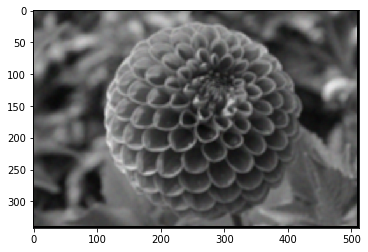

In [24]:
nlm_image = np.clip(nlm_image,0,255).astype(np.uint8)
plt.imshow(nlm_image, 'gray')
plt.show()

In [25]:
diff(image, nlm_image)

6.85073251705653